# Pipeline

Grâce au notebook analyse_dataset, la pipeline suivante à pu être faite. Ce qui optimise le nettoyage d'un dataframe similaire en entrée.

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

class DataPipeline:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df_pip = None
        self.df_pip_clean = None
        self.user_gender_encoded = None
        self.encoders = {}
        self.column_terms = {}
        self.df_pip_encoded = None

    def load_data(self):
        csv_path = os.path.join(self.data_path)
        self.df_pip = pd.read_csv(csv_path)

    def drop_columns(self, columns_to_drop):
        self.df_pip_clean = self.df_pip.drop(columns_to_drop, axis=1)

    def dropna(self, column):
        self.df_pip_clean.dropna(subset=[column], inplace=True)

    def encode_label(self, column):
        data = self.df_pip_clean[column].copy()
        le = LabelEncoder().fit(data)
        encoded_data = le.transform(data)
        self.encoders[column] = le
        return encoded_data

    def preprocess_vectors(self, vector_columns):
        vectors_pip = self.df_pip_clean[vector_columns].copy()
        for column in vectors_pip.columns:
            for i in tqdm(range(len(self.df_pip)), desc=('preprocess_vectors ' + column)):
                try:
                    vectors_pip[column][i] = [word.strip() for word in vectors_pip[column][i][1:-1].split(',')]
                except:
                    pass
        self.vectors_pip = vectors_pip

    def encode_vectors(self):
        self.df_pip_encoded = pd.DataFrame()
        for column in tqdm(self.vectors_pip.columns, desc='encode_vectors'):
            flattened_col = [e for sublist in self.vectors_pip[column] for e in sublist]
            encoder = LabelEncoder()
            encoder.fit(flattened_col)
            self.encoders[column] = encoder

            encoded_values = [encoder.transform(sublist) for sublist in self.vectors_pip[column]]
            self.df_pip_encoded[column] = encoded_values

    def get_column_terms(self):
        for column, encoder in self.encoders.items():
            terms = encoder.classes_
            self.column_terms[column] = terms.tolist()

    def one_hot_encode(self):
        progressbar_ohe1 = tqdm(total=1, desc='Encoding device_vector')
        df_device_vector = pd.get_dummies(
            self.df_pip_encoded['device_vector'].apply(pd.Series).stack(), prefix='device'
        ).sum(level=0)
        progressbar_ohe1.update(1)

        progressbar_ohe2 = tqdm(total=1, desc='Encoding channels_vector')
        df_pip_encoded_columns = pd.concat([
            df_device_vector,
            pd.get_dummies(
                self.df_pip_encoded['channels_vector'].apply(pd.Series).stack(),
                prefix='channel'
            ).sum(level=0)
        ], axis=1)
        progressbar_ohe2.update(1)

        progressbar_ohe3 = tqdm(total=1, desc='Encoding program_genre_vector')
        df_pip_encoded_columns = pd.concat([
            df_pip_encoded_columns,
            pd.get_dummies(
                self.df_pip_encoded['program_genre_vector'].apply(pd.Series).stack(),
                prefix='genre'
            ).sum(level=0)
        ], axis=1)
        progressbar_ohe3.update(1)

        self.df_pip_encoded_columns = df_pip_encoded_columns
        self.df_pip_encoded_columns.columns = (
            self.column_terms['device_vector']
            + self.column_terms['channels_vector']
            + self.column_terms['program_genre_vector']
        )
        
        progressbar_ohe1.close()
        progressbar_ohe2.close()
        progressbar_ohe3.close()


    def drop_encoded_columns(self, columns_to_drop):
        self.df_pip_encoded = self.df_pip_encoded_columns.drop(columns_to_drop, axis=1).copy()

    def add_user_gender(self, user_gender_encoded):
        self.df_pip_encoded['user_gender'] = user_gender_encoded

    def run_pipeline(self):
        self.load_data()
        self.drop_columns(["user_id", "timestamps_vector", "programs"])
        self.dropna('user_gender')
        self.user_gender_encoded = self.encode_label('user_gender')
        self.preprocess_vectors(["device_vector", "channels_vector", "program_genre_vector"])
        self.encode_vectors()
        self.get_column_terms()
        self.one_hot_encode()
        columns_to_drop = ['lci', 'Autre', 'Concert', 'Evènement', 'Fiction', 'Film',
                           'Jeunesse', 'Long-métrage', 'Météo', 'Programme FDJ', 'Programme court',
                           'Programme sponsorisé', 'Ready-made', 'Spectacle', 'Téléachat']
        self.drop_encoded_columns(columns_to_drop)
        self.add_user_gender(self.user_gender_encoded)


Environ 7 min pour le dataset de 282819 lignes fourni

In [2]:
pipeline = DataPipeline(data_path='data.csv')
pipeline.run_pipeline()

df_pip_encoded = pipeline.df_pip_encoded

Encoding device_vector:   0%|                                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]C:\Users\redh0\AppData\Local\Temp\ipykernel_30404\1928524951.py:61: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_device_vector = pd.get_dummies(
Encoding channels_vector:   0%|                                                                                                                                                                                  | 0/1 [00:00<?, ?it/s]C:\Users\redh0\AppData\Local\Temp\ipykernel_30404\1928524951.py:69: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(

In [3]:
pd.set_option('display.max_columns', None)
df_pip_encoded

,desktop,mobile,tablet,hd1,nt1,tf1,tmc,xtra,Divertissement,Documentaire,Evènement sportif,Jeu,Journal télévisé,Magazine,Magazine d'information,Magazine sportif,Mini-série,Shortcom,Série,Télé-réalité,Téléfilm,user_gender
0,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
1,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0
2,4,0,0,0,0,4,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1
3,5,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
4,5,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270091,0,3,0,0,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
270092,3,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,2,0
270093,0,4,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0
270094,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0


# Prédiction à partir de deux modèles

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
def prepare_data(df):
    X = df.drop('user_gender', axis=1)
    y = df['user_gender']
    return X, y

In [6]:
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Réseau de neurones

In [7]:
def build_model(input_shape, optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
def train_model(model, X_train, y_train, epochs=10, batch_size=64):
    for epoch in tqdm(range(epochs), desc='Training Progress'):
        model.fit(X_train, y_train, batch_size=batch_size, validation_split=0.1, verbose=0)

## Random forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

def build_random_forest_model():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    return model

In [10]:
def train_random_forest_model(model, X_train, y_train, epochs=5):
    for epoch in tqdm(range(epochs), desc='Training Progress'):
        model.fit(X_train, y_train)

----------

In [11]:
def pred_to_bin(y_pred):
    i = 0
    for val in y_pred:
        if val < 0.5:
            y_pred[i] = 0
        else:
            y_pred[i] = 1
        i += 1
    return y_pred

----------

## Evaluation du modèle

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Loss:', loss)
    print('Accuracy:', accuracy)

    y_pred = model.predict(X_test)
    
    y_pred = pred_to_bin(y_pred)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

## Train test split

In [13]:
X, y = prepare_data(df_pip_encoded)
X_train, X_test, y_train, y_test = split_data(X, y)

## Evaluation du réseau de neurones

In [14]:
model = build_model(input_shape=X_train.shape[1:])
train_model(model, X_train, y_train)

Training Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


In [15]:
evaluate_model(model, X_test, y_test)

1689/1689 [==============================] - 1s 591us/step - loss: 0.6078 - accuracy: 0.6623
Loss: 0.6078121662139893
Accuracy: 0.6622917652130127
1689/1689 [==============================] - 1s 517us/step
Precision: 0.5861737108027909
Recall: 0.3584248724990192
F1 Score: 0.4448434314232677


## Evaluation de la random forest

In [16]:
rf_model = build_random_forest_model()
train_random_forest_model(model, X_train, y_train)

Training Progress:   0%|                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

6753/6753 [==============================] - 5s 787us/step - loss: 0.6083 - accuracy: 0.6594


Training Progress:  20%|███████████████████████████████████▍                                                                                                                                             | 1/5 [00:05<00:21,  5.38s/it]

6753/6753 [==============================] - 5s 782us/step - loss: 0.6078 - accuracy: 0.6594


Training Progress:  40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 2/5 [00:10<00:16,  5.36s/it]

6753/6753 [==============================] - 6s 836us/step - loss: 0.6080 - accuracy: 0.6592


Training Progress:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 3/5 [00:16<00:11,  5.52s/it]

6753/6753 [==============================] - 5s 805us/step - loss: 0.6078 - accuracy: 0.6594


Training Progress:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4/5 [00:21<00:05,  5.51s/it]

6753/6753 [==============================] - 5s 798us/step - loss: 0.6078 - accuracy: 0.6595


Training Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.48s/it]


In [17]:
y_pred_rf = model.predict(X_test)

y_pred_rf = pred_to_bin(y_pred_rf)

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

1689/1689 [==============================] - 1s 545us/step
Accuracy: 0.6586079229914846
Precision: 0.619280645950575
Recall: 0.24823460180462928
F1 Score: 0.35440733739410485


## Comparaison des deux modèles

1689/1689 [==============================] - 1s 510us/step


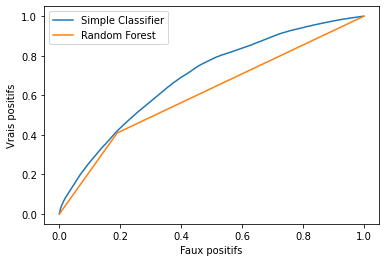

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

faux_positifs, vrais_positifs, seuils = roc_curve(y_test, y_pred)
plt.plot(faux_positifs, vrais_positifs, label="Simple Classifier")

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

faux_positifs_rf, vrais_positifs_rf, seuils_rf = roc_curve(y_test, y_pred_rf)
plt.plot(faux_positifs_rf, vrais_positifs_rf, label="Random Forest")

plt.xlabel("Faux positifs")
plt.ylabel("Vrais positifs")
plt.legend()
plt.show()


new_data_f et new_data_m correspondent tous deux à la ligne 1 et 3 de df_pip_encoded sans la colonne 'user_gender' (puisque c'est la colonne cible).

In [19]:
# En considérant de nouvelles données prétraitées :

new_data_f = {
    'desktop': [0],
    'mobile': [4],
    'tablet': [0],
    'hd1': [0],
    'nt1': [0],
    'tf1': [4],
    'tmc': [0],
    'xtra': [0],
    'Divertissement': [0],
    'Documentaire': [0],
    'Evènement sportif': [0],
    'Jeu': [0],
    'Journal télévisé': [0],
    'Magazine': [0],
    'Magazine d\'information': [0],
    'Magazine sportif': [0],
    'Mini-série': [0],
    'Shortcom': [0],
    'Série': [4],
    'Télé-réalité': [0],
    'Téléfilm': [0],
}

new_df_f = pd.DataFrame(new_data_f)

In [20]:
# En considérant de nouvelles données prétraitées :

new_data_m = {
    'desktop': [4],
    'mobile': [0],
    'tablet': [0],
    'hd1': [0],
    'nt1': [0],
    'tf1': [2],
    'tmc': [0],
    'xtra': [0],
    'Divertissement': [0],
    'Documentaire': [0],
    'Evènement sportif': [2],
    'Jeu': [0],
    'Journal télévisé': [0],
    'Magazine': [0],
    'Magazine d\'information': [0],
    'Magazine sportif': [0],
    'Mini-série': [0],
    'Shortcom': [0],
    'Série': [0],
    'Télé-réalité': [0],
    'Téléfilm': [0],
}

new_df_m = pd.DataFrame(new_data_m)

In [21]:
predictions = rf_model.predict(new_df_f)
predictions

array([0])

In [22]:
predictions = rf_model.predict(new_df_m)
predictions

array([1])

In [23]:
def preds_to_bin(predictions):
    i = 0
    for pred in predictions[0]:
        if predictions[0][i] < 0.5:
            predictions[0][i] = 0
        else:
            predictions[0][i] = 1
        i+=1
    return predictions

In [24]:
predictions = model.predict(new_df_f)
predictions = preds_to_bin(predictions)

predictions

1/1 [==============================] - 0s 39ms/step


array([[0.]], dtype=float32)

In [25]:
predictions = model.predict(new_df_m)
predictions = preds_to_bin(predictions)

predictions

1/1 [==============================] - 0s 15ms/step


array([[1.]], dtype=float32)